# Subset Genes in Adata
## This file allows saving a feature subset version of adata with the subset defined by a gene ids text file
## It also includes visualization through PCA of the adata before and after the subsetting

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score,  silhouette_samples

# Subset Adata

## Load data

In [41]:
input_adata_file = "Datasets/tpm_unstranded.h5ad"
input_genes_file = "final_gene_list_non_correlated.txt"

In [42]:
# Load original adata
adata = sc.read_h5ad(input_adata_file)
print(adata)

AnnData object with n_obs × n_vars = 2008 × 60660
    obs: 'sample_type'
    var: 'gene_name', 'gene_type'


/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [43]:
# Output file path to store subset adata
prefix = input_adata_file.split(".h5ad")[0]
output_file = prefix + "_subset.h5ad"

In [44]:
# Load the gene subset file
with open(input_genes_file, "r") as f:
    gene_subset = [line.strip() for line in f if line.strip()]

In [45]:
len(gene_subset)

9363

## Subset adata and save it

In [72]:
# Get subset of data
adata_subset = adata[:, adata.var_names.isin(gene_subset)].copy()

/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [47]:
# Save it to an output file
adata_subset.write(output_file)
adata_subset

AnnData object with n_obs × n_vars = 2008 × 9363
    obs: 'sample_type'
    var: 'gene_name', 'gene_type'

# Visualization of data with complete and reduced feature set

## Add clinical annotations to samples

In [ ]:
sample_sheet = pd.read_csv("labels.tsv", sep='\t')
clinical = pd.read_csv("clinical.tsv", sep='\t', low_memory=False)

In [48]:
df = pd.DataFrame(
    data=adata.X,
    index=adata.obs_names,         # sample IDs as row index
    columns=adata.var_names        # gene_ids as column names
)

In [49]:
df = df.T

In [50]:
clinical_columns_to_keep = [
    'case_submitter_id',
    'gender',
    'age_at_index',
    'race',
    'initial_disease_status',
    # 'vital_status',
    'ajcc_pathologic_stage',
    'classification_of_tumor',
    'primary_diagnosis',
    #'tissue_or_organ_of_origin',
    #'ttherapeutic_agents',
    #'treatment_type',
    # 'ajcc_pathologic_n',
    # 'ajcc_pathologic_t',
    # 'ajcc_pathologic_m'
]

In [51]:
columns_to_group = [
    'gender',
    'age_at_index',
    'race',
    'initial_disease_status',
    'ajcc_pathologic_stage',
    'classification_of_tumor',
    'primary_diagnosis',
]

In [80]:
columns_to_group_dict = {
    'Gender': 'gender',
    'Age': 'age_at_index',
    'Race': 'race',
    'Initial Disease Status': 'initial_disease_status',
    'Pathological Stage': 'ajcc_pathologic_stage',
    'Tumor Classification':'classification_of_tumor',
    'Primary Diagnosis': 'primary_diagnosis',
}

In [53]:
# Build sample-to-case map
sample_to_case = sample_sheet[['File ID', 'Case ID']].dropna()
sample_to_case = sample_to_case[sample_to_case['File ID'].isin(df.columns)]
clinical_unique = clinical.drop_duplicates(subset='case_submitter_id')
print(f"Unique Clinical Rows:{len(clinical_unique)}"

In [60]:
clinical_subset = clinical_unique[clinical_columns_to_keep]

In [61]:
sample_clinical = pd.merge(sample_to_case, clinical_subset,
                           left_on='Case ID',
                           right_on='case_submitter_id',
                           how='left')

In [62]:
sample_clinical.index = sample_clinical['File ID']
sample_clinical = sample_clinical.drop('File ID', axis =1)

In [63]:
# reorder to match original order
sample_clinical = sample_clinical.loc[df.columns.intersection(sample_clinical.index)]

In [64]:
# Modify normal samples to have NA label for these
clinical_disease_columns = [
    'initial_disease_status',
    'ajcc_pathologic_stage',
    'classification_of_tumor',
    'primary_diagnosis',
]

In [65]:
definitely_cancer_labels = [
    "Primary Tumor",
    "Primary Tumor, Primary Tumor",
    "Primary Tumor, Primary Tumor, Primary Tumor",
    "Primary Tumor, Primary Tumor, Primary Tumor, Primary Tumor, Primary Tumor",
    "Metastatic",
    "Recurrent Tumor",
    "Next Generation Cancer Model",
    "Expanded Next Generation Cancer Model"
]

In [66]:
normal_samples = sample_sheet[~sample_sheet['Sample Type'].isin(definitely_cancer_labels)]['File ID']

In [67]:
for col in clinical_disease_columns:
    sample_clinical.loc[normal_samples, col] = "NA/Normal Sample"

In [68]:
adata

AnnData object with n_obs × n_vars = 2008 × 60660
    obs: 'sample_type'
    var: 'gene_name', 'gene_type'

In [69]:
adata.X = df.T

In [70]:
for col in columns_to_group:
   adata.obs[col] = sample_clinical[col].copy()

In [71]:
adata.obs

,sample_type,gender,age_at_index,race,initial_disease_status,ajcc_pathologic_stage,classification_of_tumor,primary_diagnosis
00000c20-b875-4821-8d4b-c50d7a7f9879,Primary Tumor,male,59,white,'--,'--,Prior primary,"Neoplasm, NOS"
000b6b94-572d-4d06-a8f4-2e43829f83d4,Primary Tumor,male,53,white,'--,Stage IIA,primary,"Squamous cell carcinoma, NOS"
0052ae83-7ae5-470a-a125-5cd94a9fa9e9,Primary Tumor,male,61,white,'--,Stage IIIA,primary,"Adenocarcinoma, NOS"
00810078-a4fc-4e1d-bbdc-e5e0d3080025,Primary Tumor,male,57,white,'--,Stage IB,primary,"Squamous cell carcinoma, NOS"
00ad0370-5339-4136-800c-56d4250af0ab,Primary Tumor,male,'--,black or african american,'--,'--,Prior primary,Not Reported
...,...,...,...,...,...,...,...,...
fec22982-c32a-44bd-a1bb-0a377ed028e7,"Primary Tumor, Primary Tumor",NaN,NaN,NaN,NaN,NaN,NaN,NaN
fefb2a51-9eff-464a-bb88-99b886e31698,"Primary Tumor, Primary Tumor",NaN,NaN,NaN,NaN,NaN,NaN,NaN
ff184d74-848e-4a36-b52a-f1304f0996bc,Primary Tumor,male,'--,asian,'--,Stage IIIA,'--,"Adenocarcinoma, NOS"
ffc619ed-9dc5-4364-9384-46c9a7fee273,Solid Tissue Normal,male,'--,asian,NA/Normal Sample,NA/Normal Sample,NA/Normal Sample,NA/Normal Sample


In [ ]:
# Subset again to get the adata subset with the annotations
adata_subset = adata[:, adata.var_names.isin(gene_subset)].copy()

## Visualize data using PCA

In [2]:
## Compute embeddings and log transform
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

NameError: name 'sc' is not defined

In [ ]:
sc.pp.log1p(adata_subset)
sc.tl.pca(adata_subset)
sc.pp.neighbors(adata_subset)
sc.tl.umap(adata_subset)

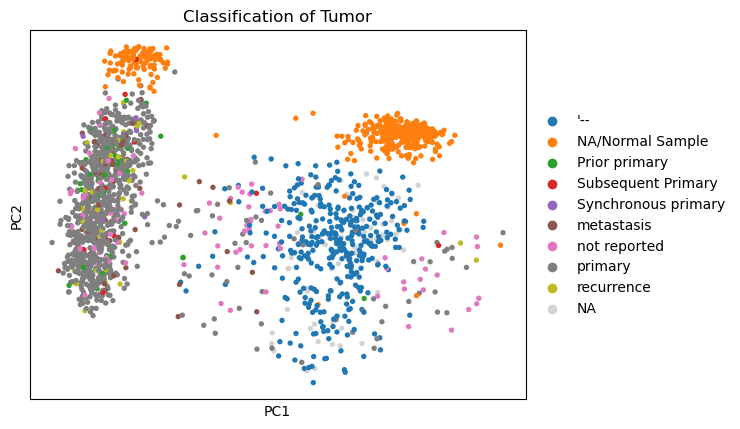

In [75]:
key = 'classification_of_tumor'
sc.pl.pca(adata, color=key, title='Classification of Tumor')

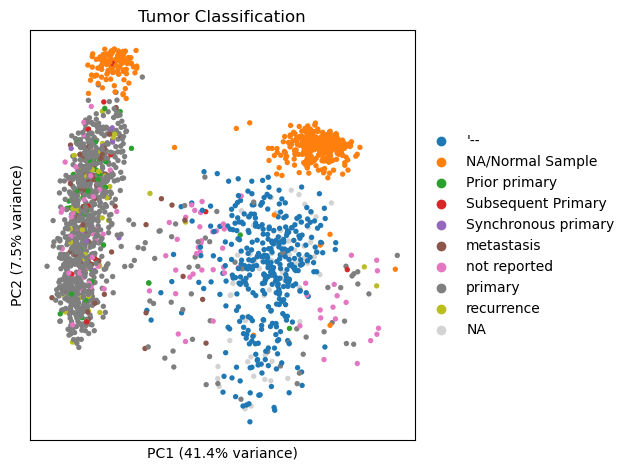

In [92]:
var_ratios = adata.uns['pca']['variance_ratio']

pc1, pc2 = 0, 1
sc.pl.pca(adata, color='classification_of_tumor', title='Tumor Classification', show=False)
plt.xlabel(f'PC{pc1+1} ({var_ratios[pc1]*100:.1f}% variance)')
plt.ylabel(f'PC{pc2+1} ({var_ratios[pc2]*100:.1f}% variance)')
plt.tight_layout()
plt.show()

In [86]:
pca_coords = adata.obsm['X_pca']
for key in columns_to_group_dict:
    labels = adata.obs[columns_to_group_dict[key]]
    
    # Create a boolean mask for non-NaN labels
    valid_mask = labels.notna()
    
    # Filter coordinates and labels
    coords_filtered = pca_coords[valid_mask]
    labels_filtered = labels[valid_mask]
    
    # Compute silhouette score only on valid data
    score = silhouette_score(coords_filtered, labels_filtered)
    print(f"Silhouette score for PCA with {key} labels: {score:.3f}")

Silhouette score for PCA with Gender labels: 0.007
Silhouette score for PCA with Age labels: -0.079
Silhouette score for PCA with Race labels: -0.178
Silhouette score for PCA with Initial Disease Status labels: -0.068
Silhouette score for PCA with Pathological Stage labels: -0.169
Silhouette score for PCA with Tumor Classification labels: -0.004
Silhouette score for PCA with Primary Diagnosis labels: -0.294


In [ ]:
plt.plot(range(1, len(var_ratios)+1), var_ratios*100, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Scree Plot")
plt.show()

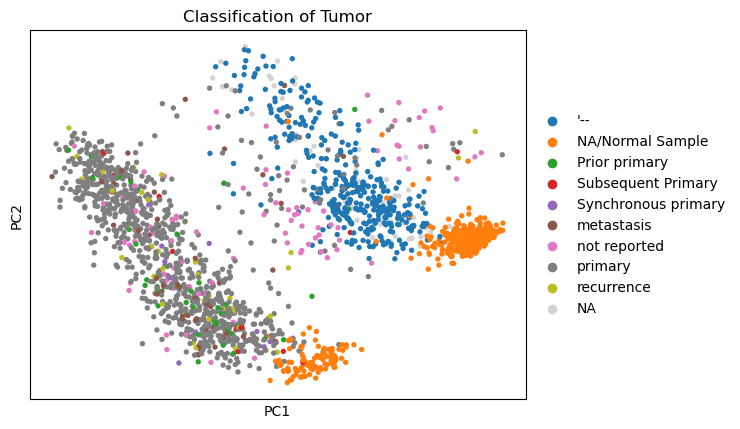

In [77]:
sc.pl.pca(adata_subset, color=key, title='Classification of Tumor')

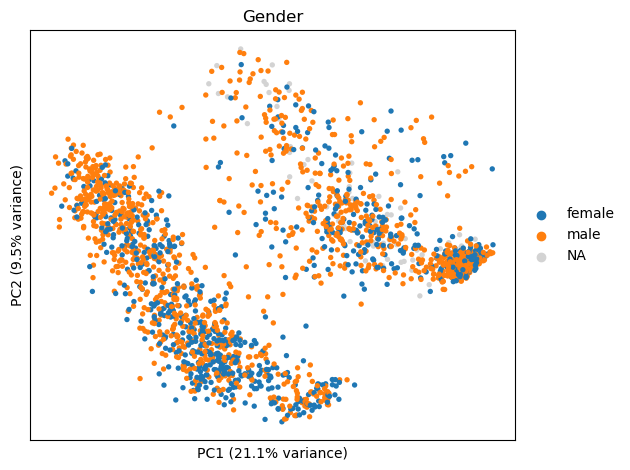

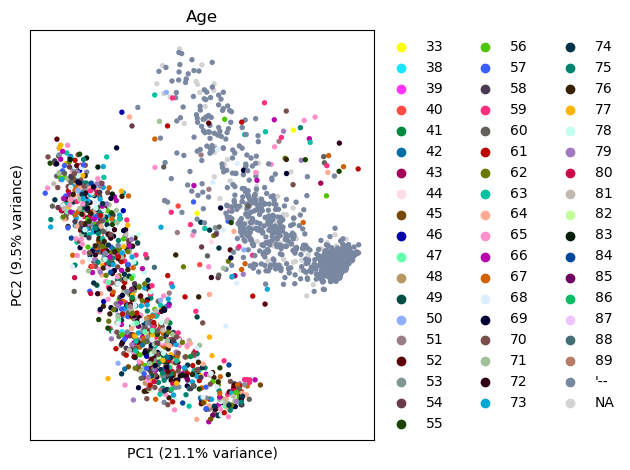

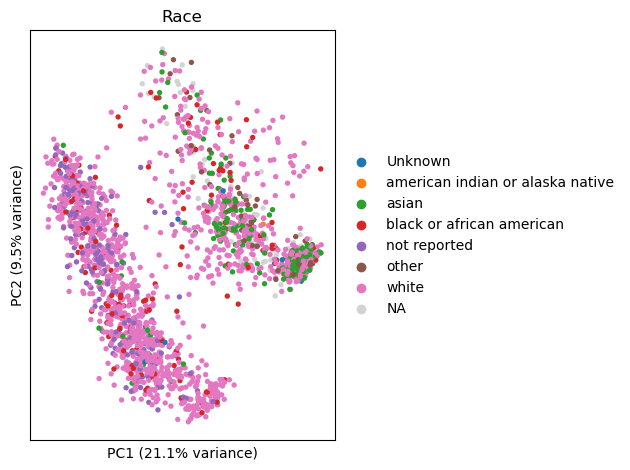

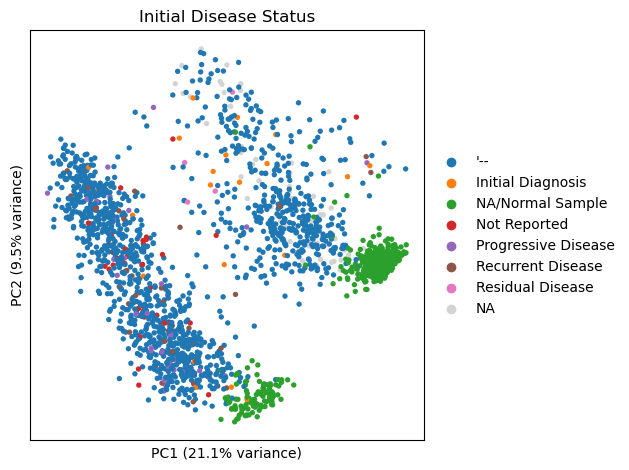

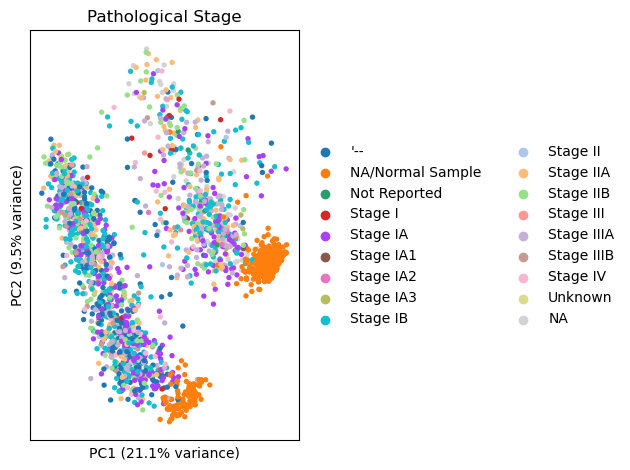

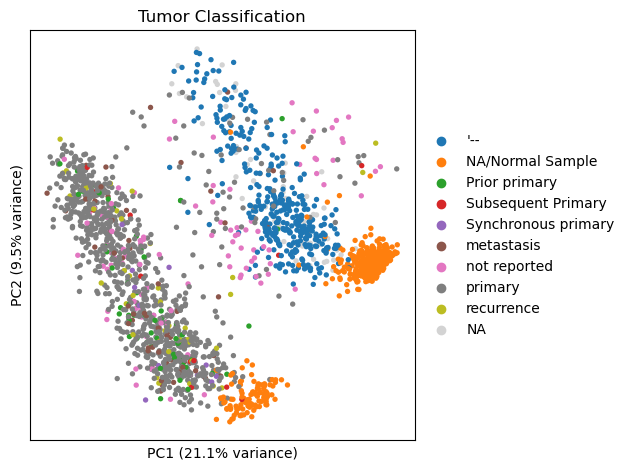

/var/folders/c4/570ty6gd42v42mmcqq8z2mrc0000gn/T/ipykernel_54667/2043830547.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


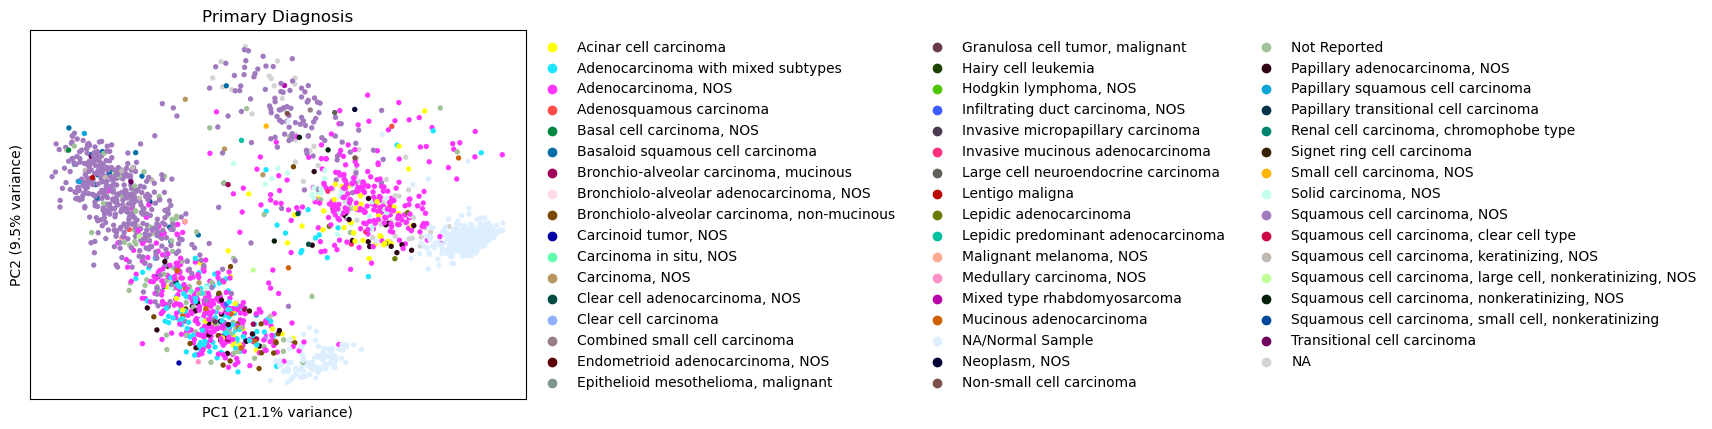

In [88]:
for key in columns_to_group_dict:
    sc.pl.pca(adata_subset, color = columns_to_group_dict[key], title = key, show=False)
    plt.xlabel(f'PC{pc1+1} ({var_ratios[pc1]*100:.1f}% variance)')
    plt.ylabel(f'PC{pc2+1} ({var_ratios[pc2]*100:.1f}% variance)')
    plt.tight_layout()
    plt.show()

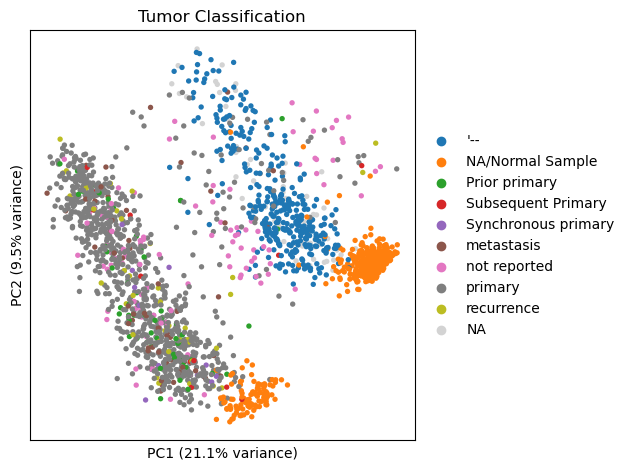

In [94]:
var_ratios = adata_subset.uns['pca']['variance_ratio']

pc1, pc2 = 0, 1
sc.pl.pca(adata_subset, color = 'classification_of_tumor', title = 'Tumor Classification', show=False)
plt.xlabel(f'PC{pc1+1} ({var_ratios[pc1]*100:.1f}% variance)')
plt.ylabel(f'PC{pc2+1} ({var_ratios[pc2]*100:.1f}% variance)')
plt.tight_layout()
plt.show()

In [87]:
pca_coords = adata_subset.obsm['X_pca']
for key in columns_to_group_dict:
    labels = adata_subset.obs[columns_to_group_dict[key]]
    
    # Create a boolean mask for non-NaN labels
    valid_mask = labels.notna()
    
    # Filter coordinates and labels
    coords_filtered = pca_coords[valid_mask]
    labels_filtered = labels[valid_mask]
    
    # Compute silhouette score only on valid data
    score = silhouette_score(coords_filtered, labels_filtered)
    print(f"Silhouette score for PCA with {key} labels: {score:.3f}")

Silhouette score for PCA with Gender labels: 0.009
Silhouette score for PCA with Age labels: -0.098
Silhouette score for PCA with Race labels: -0.098
Silhouette score for PCA with Initial Disease Status labels: 0.036
Silhouette score for PCA with Pathological Stage labels: -0.067
Silhouette score for PCA with Tumor Classification labels: 0.058
Silhouette score for PCA with Primary Diagnosis labels: -0.173


## Scree Plots

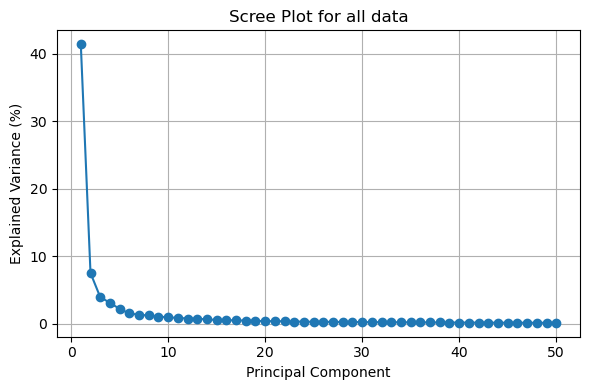

In [223]:
var_ratios = adata.uns['pca']['variance_ratio']

plt.figure(figsize=(6,4))
plt.plot(range(1, len(var_ratios)+1), var_ratios * 100, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("Scree Plot for all data")
plt.grid(True)
plt.tight_layout()
plt.show()

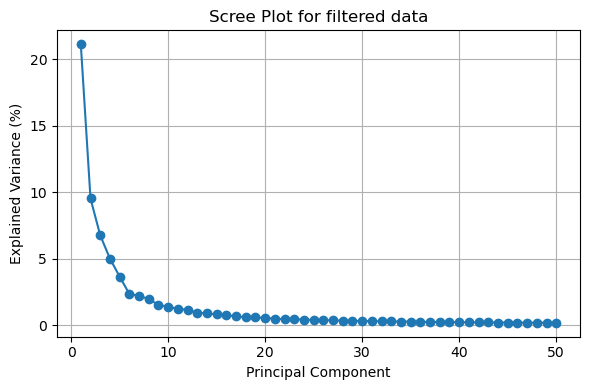

In [224]:
var_ratios = adata_subset.uns['pca']['variance_ratio']

plt.figure(figsize=(6,4))
plt.plot(range(1, len(var_ratios)+1), var_ratios * 100, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("Scree Plot for filtered data")
plt.grid(True)
plt.tight_layout()
plt.show()